In [1]:
import random
import faker
import pyodbc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import gender_guesser.detector as gender
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import RandomizedSearchCV


In [2]:
server = 'DAVID\\SQLEXPRESS'  # Nombre del servidor
database = 'BDD_PBL'  # Nombre de la base de datos
connection_string = (
    'DRIVER={SQL Server};'
    'SERVER=' + server + ';'
    'DATABASE=' + database + ';'
    'Trusted_Connection=yes;'
)

In [3]:
conn = pyodbc.connect(connection_string)

In [4]:
cursor = conn.cursor()

In [5]:
query = "SELECT * FROM data_unificada_final"
cursor.execute(query)
columns = [column[0] for column in cursor.description]
rows = cursor.fetchall()
cursor.close()
conn.close()

In [6]:
df = pd.DataFrame.from_records(rows, columns=columns)

In [7]:
fake = faker.Faker('es_ES')

In [8]:
# Función para generar un número de identificación ecuatoriano
def generate_ecuadorian_id():
    return str(random.randint(1000000000, 9999999999))

# Crear un diccionario para mantener consistencia en los nombres y las identificaciones
name_to_id = {}

# Listas para almacenar los datos sintéticos
synthetic_names = []
synthetic_ids = []

# Generar los datos sintéticos asegurando que los nombres repetidos tengan la misma identificación
for original_name in df['Nombre_completo']:
    if original_name not in name_to_id:
        # Generar nuevo nombre e identificación solo si el nombre no está en el diccionario
        new_name = fake.name()
        new_id = generate_ecuadorian_id()
        name_to_id[original_name] = (new_name, new_id)
    
    # Asignar los valores sintéticos a las listas
    synthetic_names.append(name_to_id[original_name][0])
    synthetic_ids.append(name_to_id[original_name][1])

# Asignar los nuevos datos a las columnas correspondientes
df['Nombre_completo'] = synthetic_names
df['Identificación'] = synthetic_ids
df['CodPrograma'] = df['CodPrograma'].str[4:]

In [9]:
datos = df.copy()

In [10]:
#DataFrame
print("Dimensiones del DataFrame:", datos.shape)
print("Datos nulos por columna:")
print(datos.head)
print(datos.isnull().sum())

Dimensiones del DataFrame: (49309, 25)
Datos nulos por columna:
<bound method NDFrame.head of                      Nombre_completo                       Programa  \
0           María Ángeles del Laguna  DERECHOS HUMANOS Y NATURALEZA   
1              Valeria del Francisco              SONIDO Y ACUSTICA   
2       Fabiola Salud Márquez Iborra   ELECTRONICA Y AUTOMATIZACION   
3            Olalla Aura Paz Estevez                       SOFTWARE   
4            Valentín Nicolau Morera       NEGOCIOS INTERNACIONALES   
...                              ...                            ...   
49304  Lara Luciana Cardona Granados                     INDUSTRIAL   
49305          Victorino Casado Pozo  MULTIMEDIA Y PROD.AUDIOVISUAL   
49306                Sandalio Nevado     ADMINISTRACION DE EMPRESAS   
49307                    Reyes Amaya                    GASTRONOMIA   
49308          Felicidad Mora Girona                           CINE   

      Estado_de_candidato Afluente Periodo Origen_del

In [11]:
#datos nulos
nulos = datos.isnull().sum().sum()
if nulos > 0:
    print(f"Advertencia: Se encontraron {nulos} valores nulos.")
else:
    print("No se encontraron valores nulos.")

No se encontraron valores nulos.


In [12]:
print(datos.info())
print(datos.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49309 entries, 0 to 49308
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Nombre_completo               49309 non-null  object
 1   Programa                      49309 non-null  object
 2   Estado_de_candidato           49309 non-null  object
 3   Afluente                      49309 non-null  object
 4   Periodo                       49309 non-null  object
 5   Origen_del_candidato          49309 non-null  object
 6   CodPrograma                   49309 non-null  object
 7   Genero                        49309 non-null  object
 8   Provincia                     49309 non-null  object
 9   Campaña                       49309 non-null  object
 10  TipoColegio                   49309 non-null  object
 11  Edad_grupos                   49309 non-null  object
 12  TieneDiscapacidad             49309 non-null  object
 13  TrabajaActualmen

In [13]:
print(datos.dtypes)

Nombre_completo                 object
Programa                        object
Estado_de_candidato             object
Afluente                        object
Periodo                         object
Origen_del_candidato            object
CodPrograma                     object
Genero                          object
Provincia                       object
Campaña                         object
TipoColegio                     object
Edad_grupos                     object
TieneDiscapacidad               object
TrabajaActualmente              object
TipoAdmision                    object
EstadoCivil_1                   object
CitaAdmisiones                  object
pi_score_c_grupos               object
Ciudad                          object
LeadContacto                    object
NoLlamar                        object
ListaNegra                      object
tour_c                          object
Titulo_Registrado_Senescyt_c    object
Identificación                  object
dtype: object


C:\Users\DAVID MALDONADO\AppData\Local\Temp\ipykernel_24420\1449383969.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=datos, x='Estado_de_candidato', palette='Set2')


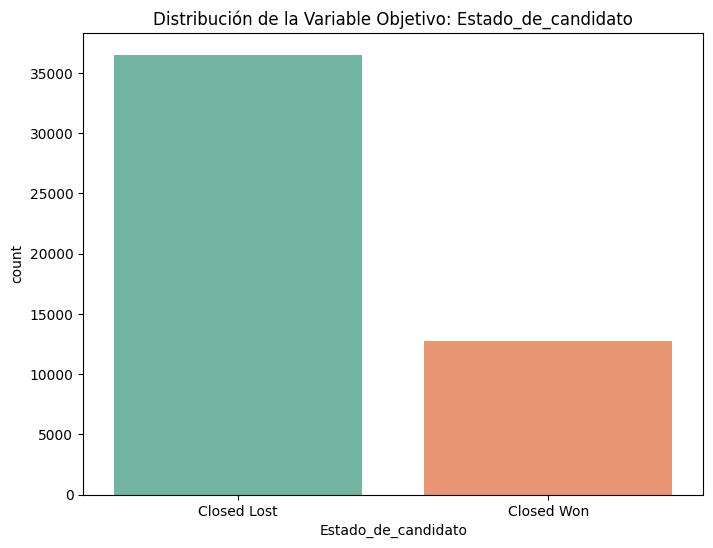

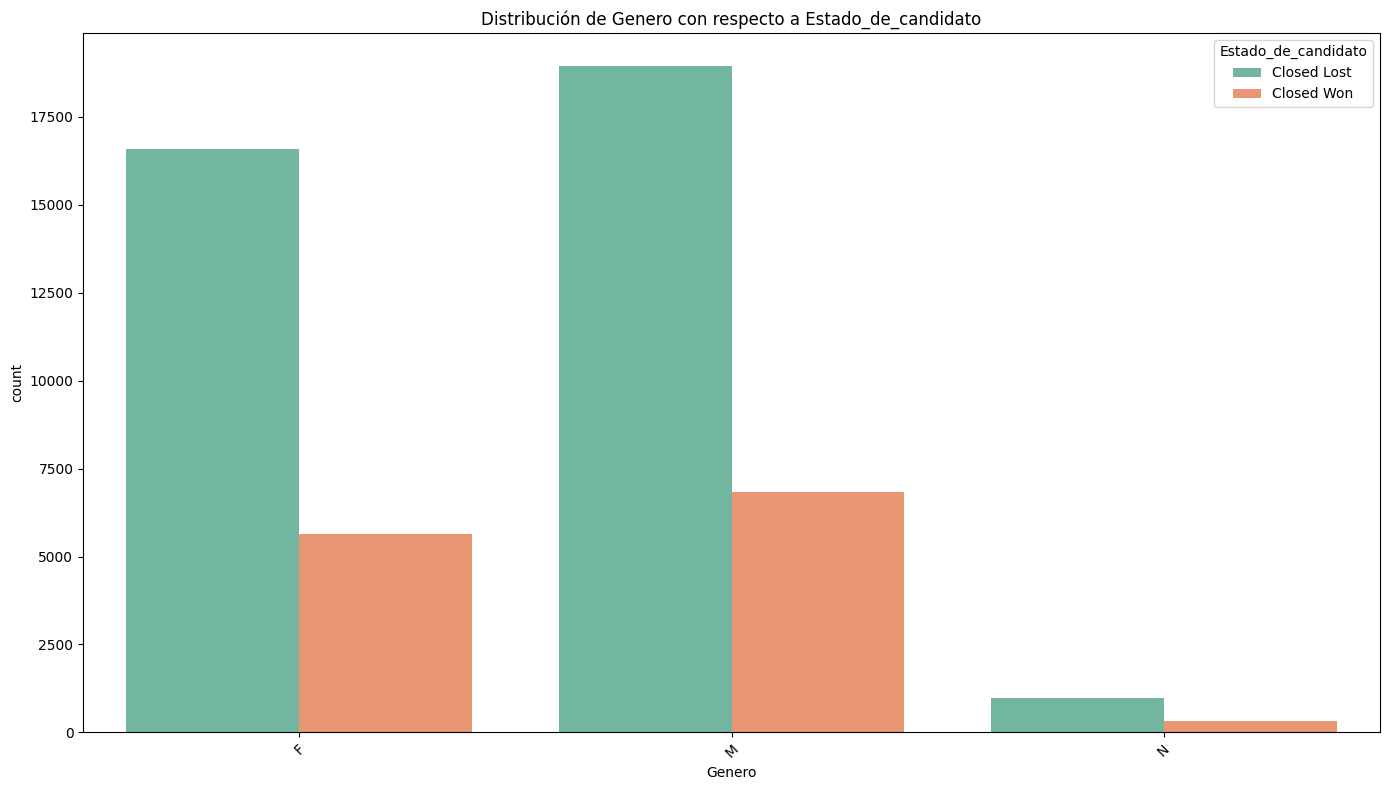

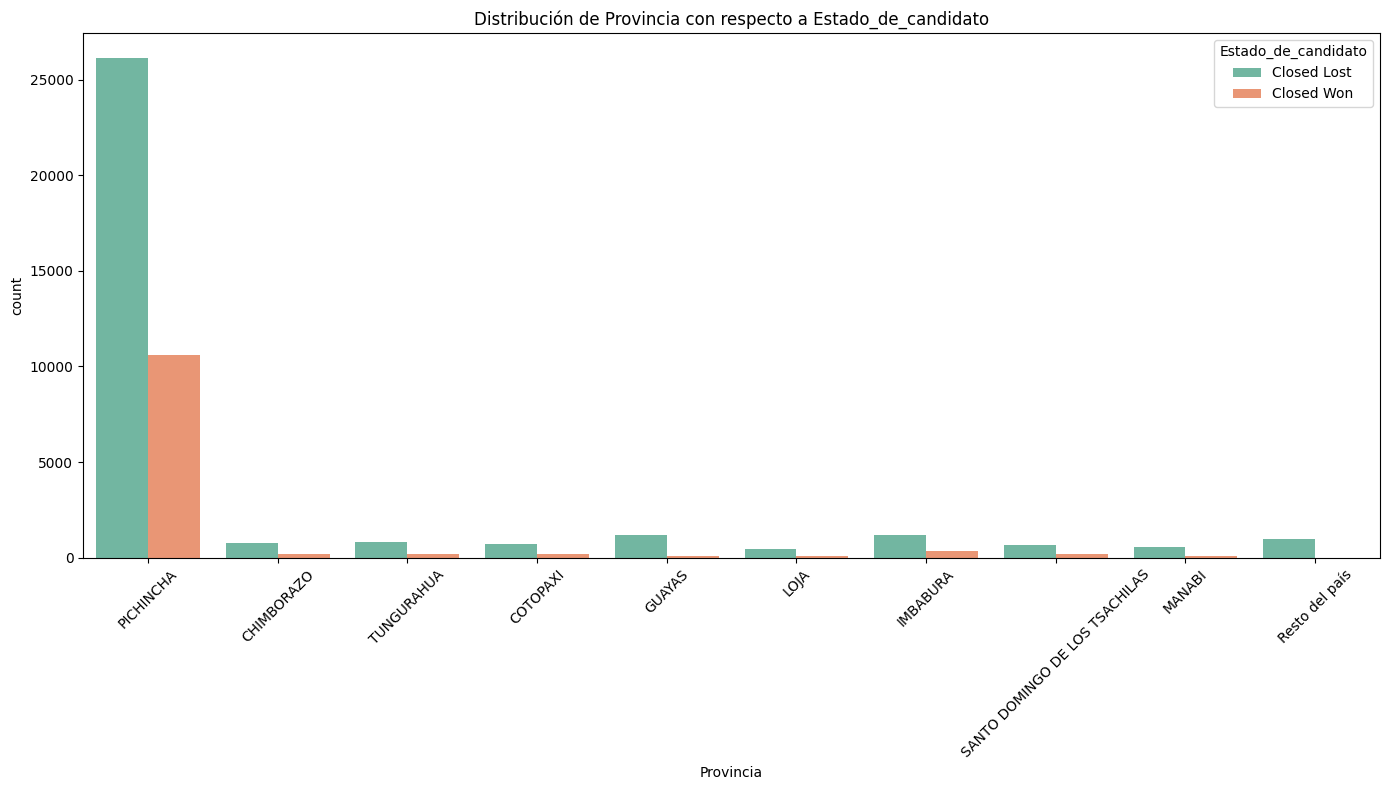

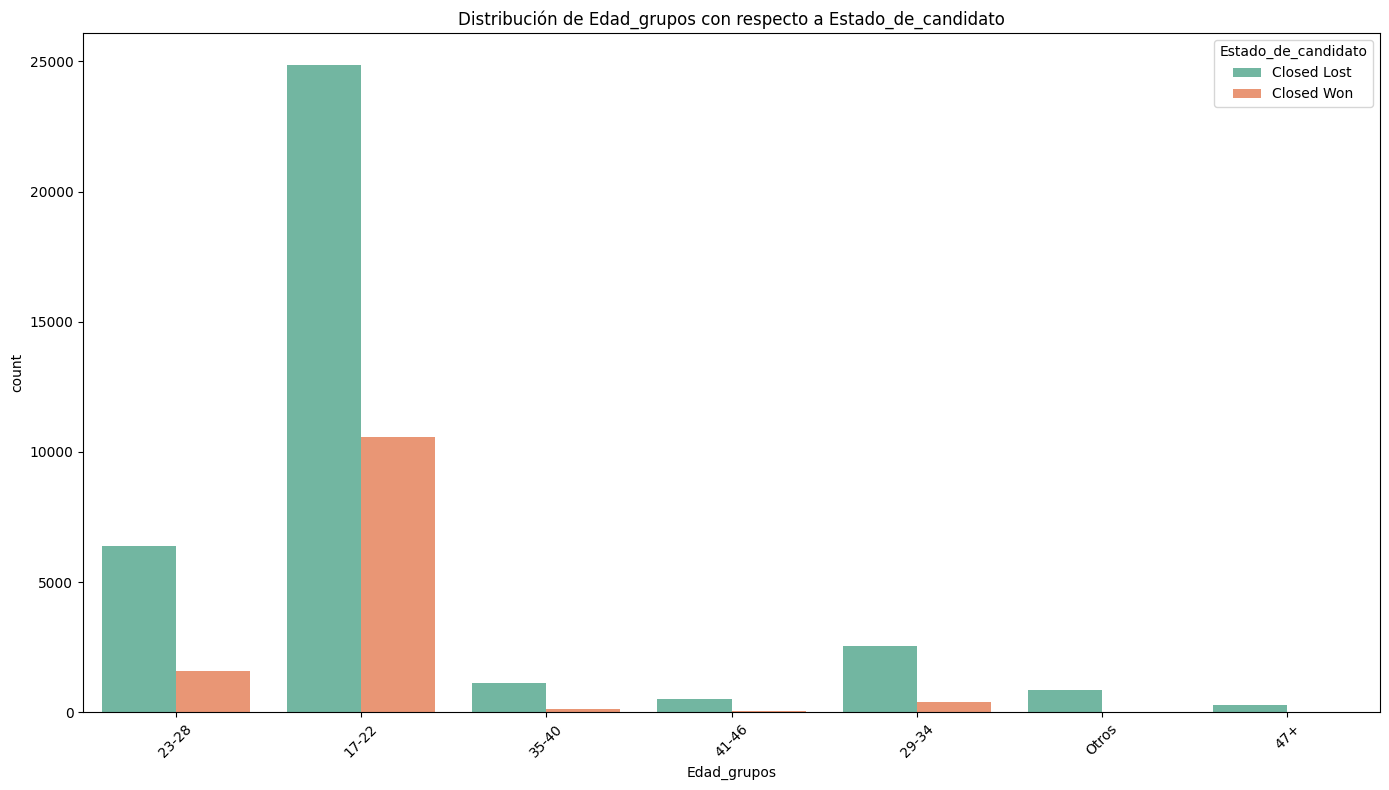

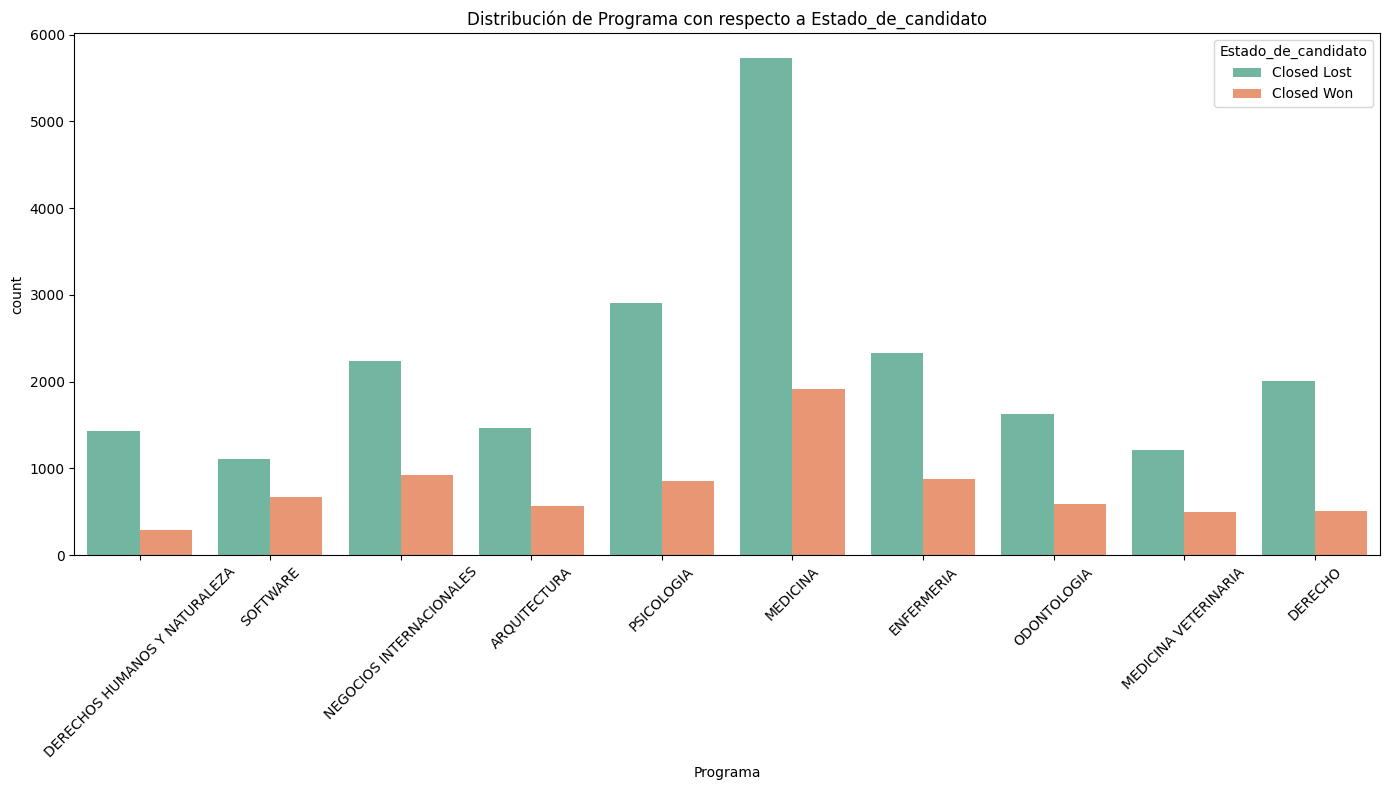

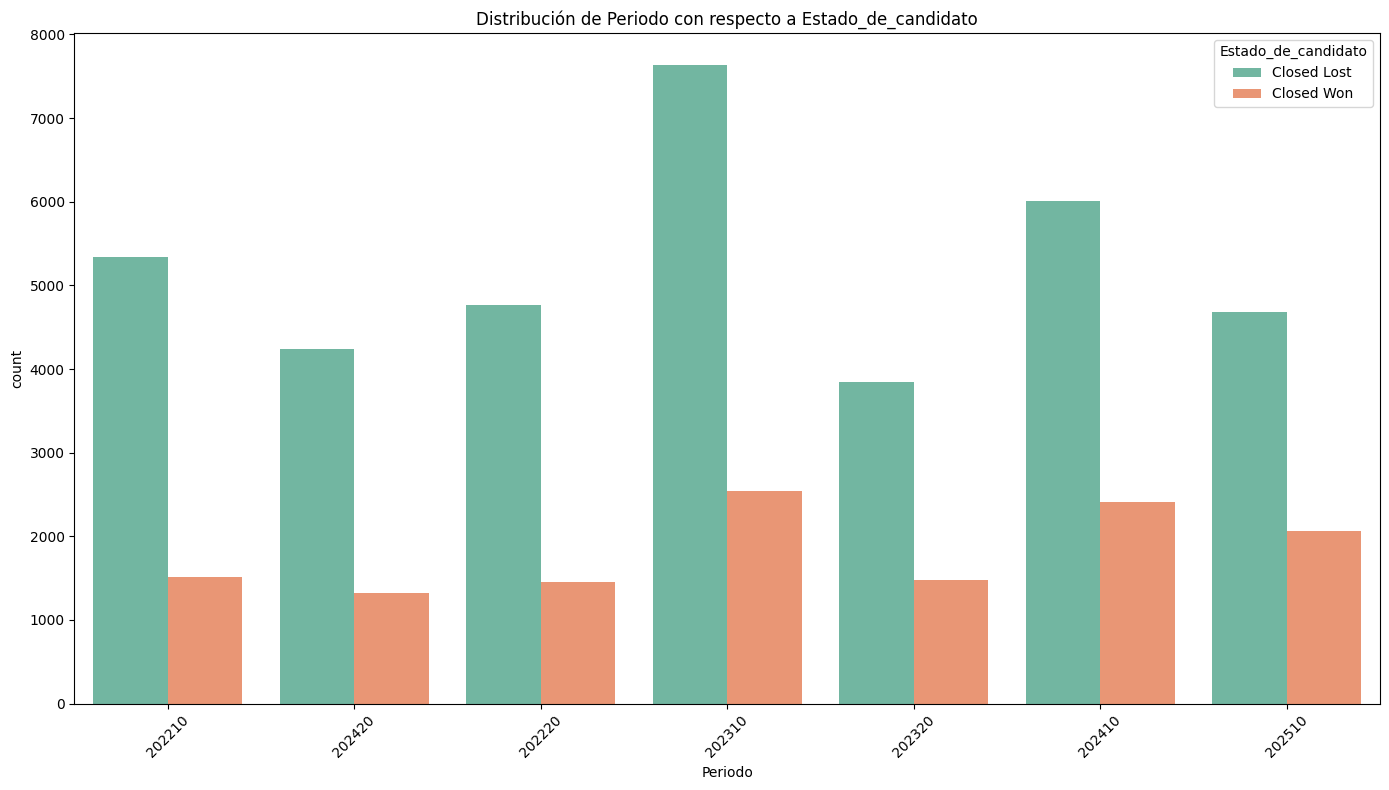

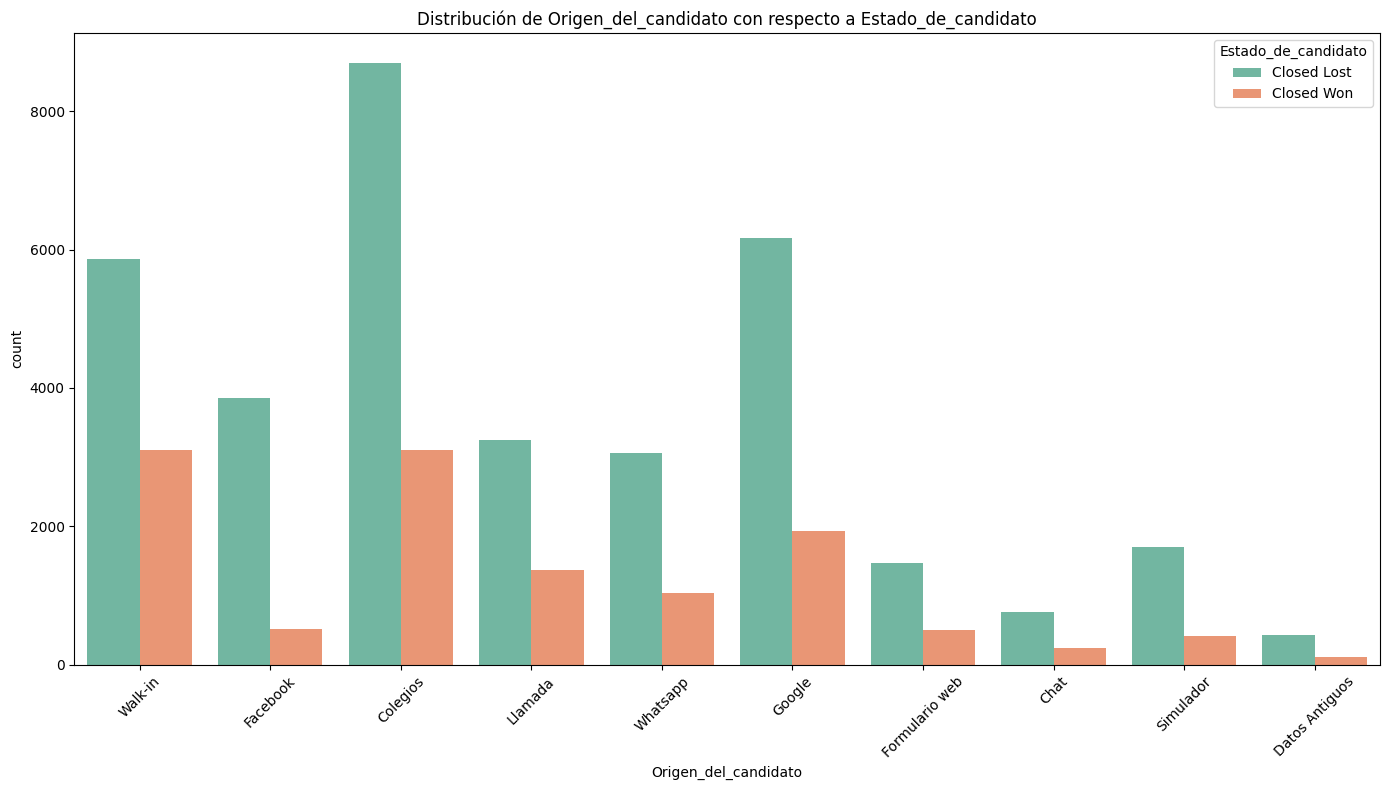

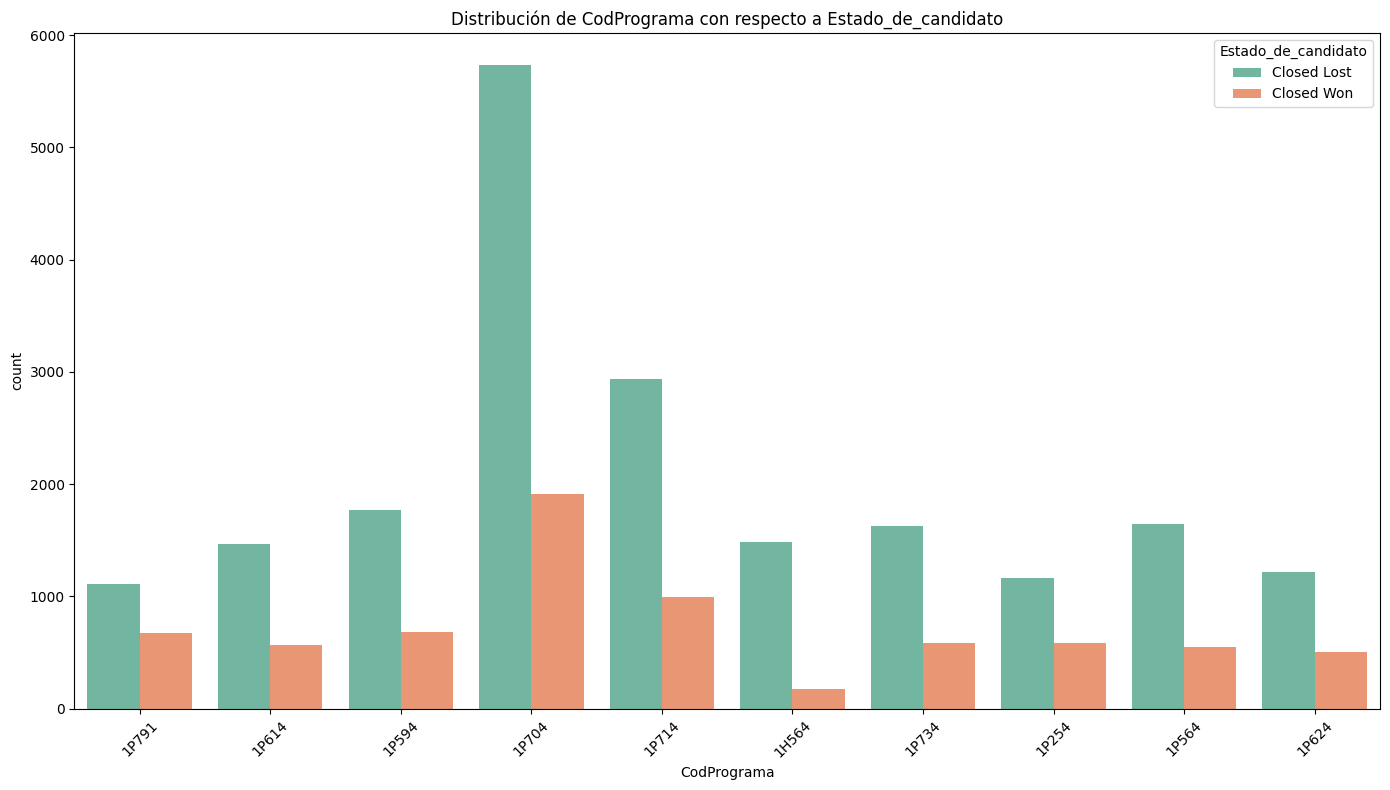

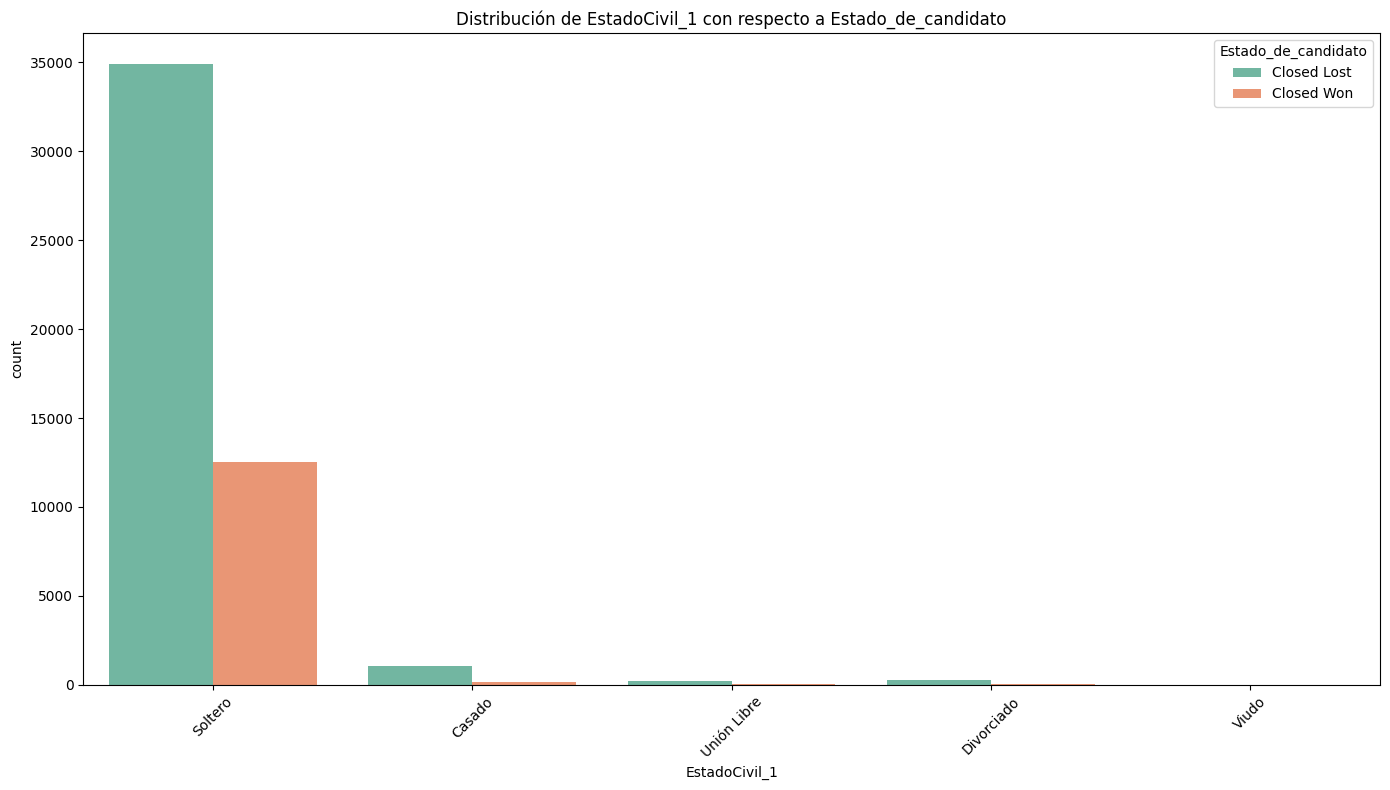

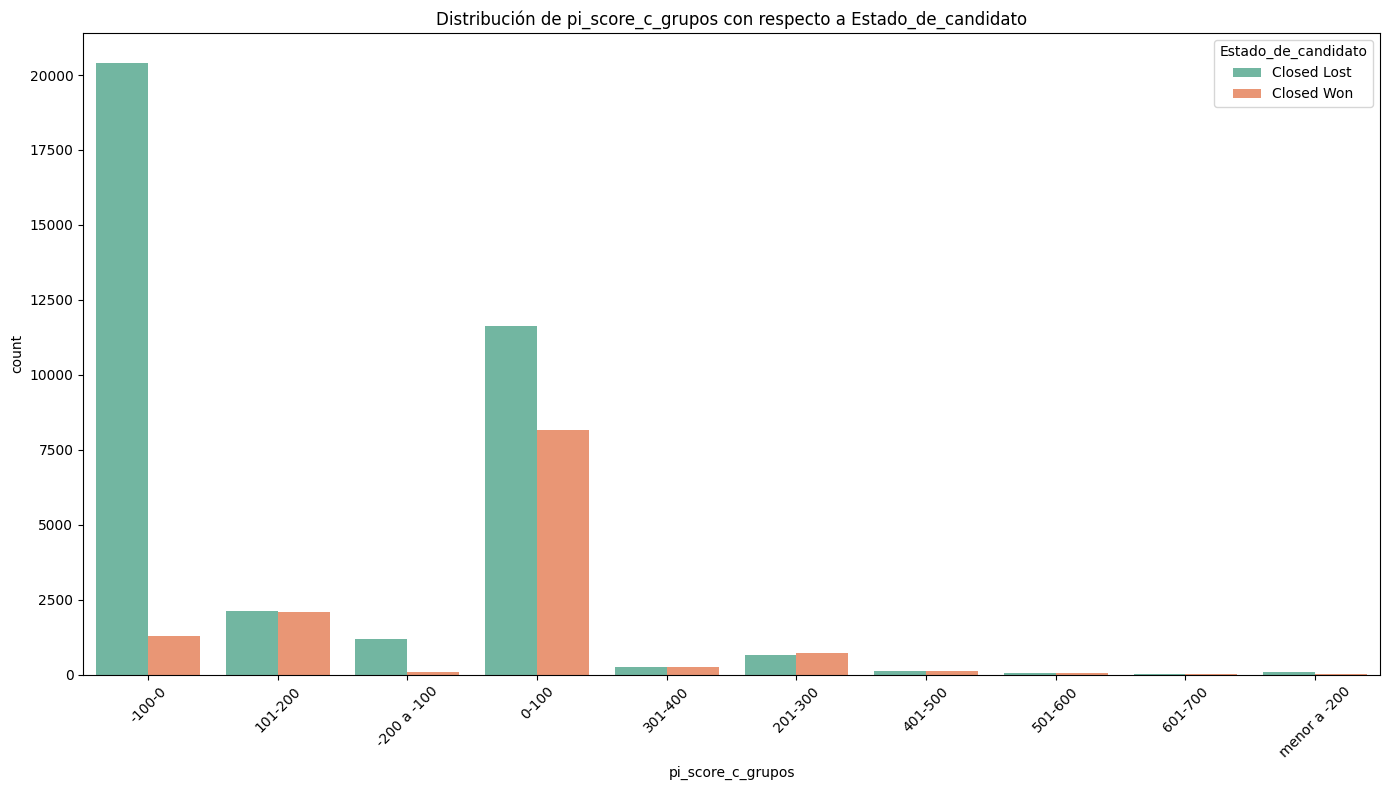

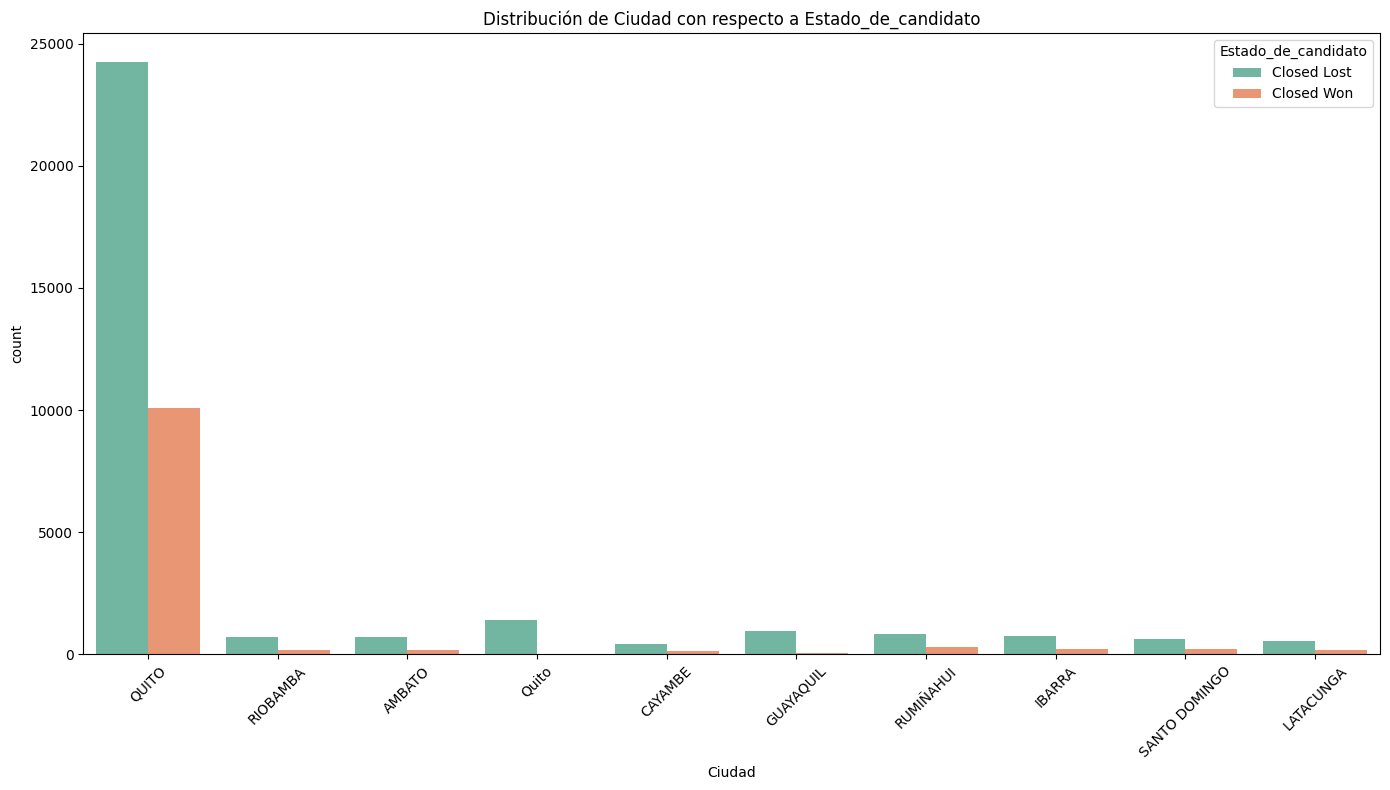

In [14]:
# Función para graficar solo las 10 categorías más frecuentes en variables con más de 10 categorías
def plot_top_10_categories(df, column, target, palette='Set2'):
    plt.figure(figsize=(14, 8))
    
    if df[column].nunique() > 10:
        top_10 = df[column].value_counts().nlargest(10).index
        sns.countplot(data=df[df[column].isin(top_10)], x=column, hue=target, palette=palette)
    else:
        sns.countplot(data=df, x=column, hue=target, palette=palette)
    
    plt.title(f'Distribución de {column} con respecto a {target}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Graficar la variable objetivo 'Estado_de_candidato'
plt.figure(figsize=(8, 6))
sns.countplot(data=datos, x='Estado_de_candidato', palette='Set2')
plt.title('Distribución de la Variable Objetivo: Estado_de_candidato')
plt.show()

# Graficar para todas las columnas categóricas
categorical_columns = ['Genero', 'Provincia', 'Edad_grupos', 'Programa', 'Periodo', 'Origen_del_candidato', 
                       'CodPrograma', 'EstadoCivil_1', 'pi_score_c_grupos', 'Ciudad']

for column in categorical_columns:
    plot_top_10_categories(datos, column, 'Estado_de_candidato')


In [15]:
print(datos['Titulo_Registrado_Senescyt_c'].drop_duplicates())

0     0
32    1
Name: Titulo_Registrado_Senescyt_c, dtype: object


In [16]:
# Omitir las columnas especificadas
#omit_columns = ['Nombre_completo', 'CodPrograma', 'LeadContacto', 'Identificación','Periodo','Ciudad']
#datos_filtered = datos.drop(columns=omit_columns)

# Paso 1: Aplicar LabelEncoder para variables categóricas binarias (con dos valores)
label_columns = ['Estado_de_candidato', 'Afluente', 'TipoColegio', 'TieneDiscapacidad', 
                 'TrabajaActualmente', 'TipoAdmision', 'CitaAdmisiones', 'NoLlamar', 
                 'ListaNegra', 'tour_c','Titulo_Registrado_Senescyt_c']

le_dict = {}  # Diccionario para guardar los codificadores y revertir luego

for column in label_columns:
    le = LabelEncoder()
    datos[column] = le.fit_transform(datos[column])
    le_dict[column] = le  # Guardar el codificador para revertir luego

# Paso 2: Aplicar OneHotEncoder para variables con más de dos categorías
one_hot_columns = ['Programa', 'Origen_del_candidato', 
                   'Genero', 'Provincia', 'Campaña', 'Edad_grupos', 'EstadoCivil_1', 
                   'pi_score_c_grupos', ]

# Guardar las columnas originales que serán OneHotEncoded
one_hot_originals = datos[one_hot_columns].copy()

# Aplicar OneHotEncoding y agregar las nuevas columnas al dataset
datos = pd.get_dummies(datos, columns=one_hot_columns, drop_first=True)

# Paso 3: Convertir las columnas que pueden ser numéricas a tipo numérico
for column in datos.columns:
    try:
        datos[column] = pd.to_numeric(datos[column])
    except ValueError:
        continue

# Mostrar las primeras filas del dataset transformado
print(datos.head())



                Nombre_completo  Estado_de_candidato  Afluente  Periodo  \
0      María Ángeles del Laguna                    0         0   202210   
1         Valeria del Francisco                    0         0   202210   
2  Fabiola Salud Márquez Iborra                    0         0   202210   
3       Olalla Aura Paz Estevez                    0         0   202210   
4       Valentín Nicolau Morera                    0         0   202210   

  CodPrograma  TipoColegio  TieneDiscapacidad  TrabajaActualmente  \
0       2P567            0                  0                   0   
1       1P634            0                  0                   0   
2       1P524            0                  0                   0   
3       1P791            0                  0                   0   
4       2P257            0                  0                   0   

   TipoAdmision  CitaAdmisiones  ... pi_score_c_grupos_101-200  \
0             0               0  ...                         0   
1 

Modelo 1: Submuestreo


c:\Users\DAVID MALDONADO\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6413 - loss: 0.9427 - val_accuracy: 0.8601 - val_loss: 0.6370
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8579 - loss: 0.6233 - val_accuracy: 0.8333 - val_loss: 0.6028
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8682 - loss: 0.5673 - val_accuracy: 0.8568 - val_loss: 0.5643
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8678 - loss: 0.5420 - val_accuracy: 0.8529 - val_loss: 0.5308
Epoch 5/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8679 - loss: 0.5202 - val_accuracy: 0.8522 - val_loss: 0.5152
Epoch 6/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8691 - loss: 0.4897 - val_accuracy: 0.8522 - val_loss: 0.4915
Epoch 7/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8690 - loss: 0.4747 - val_accuracy: 0.8522 - val_loss: 0.4831
Epoch 8/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8764 - loss: 0.4492 - val_accuracy: 0.

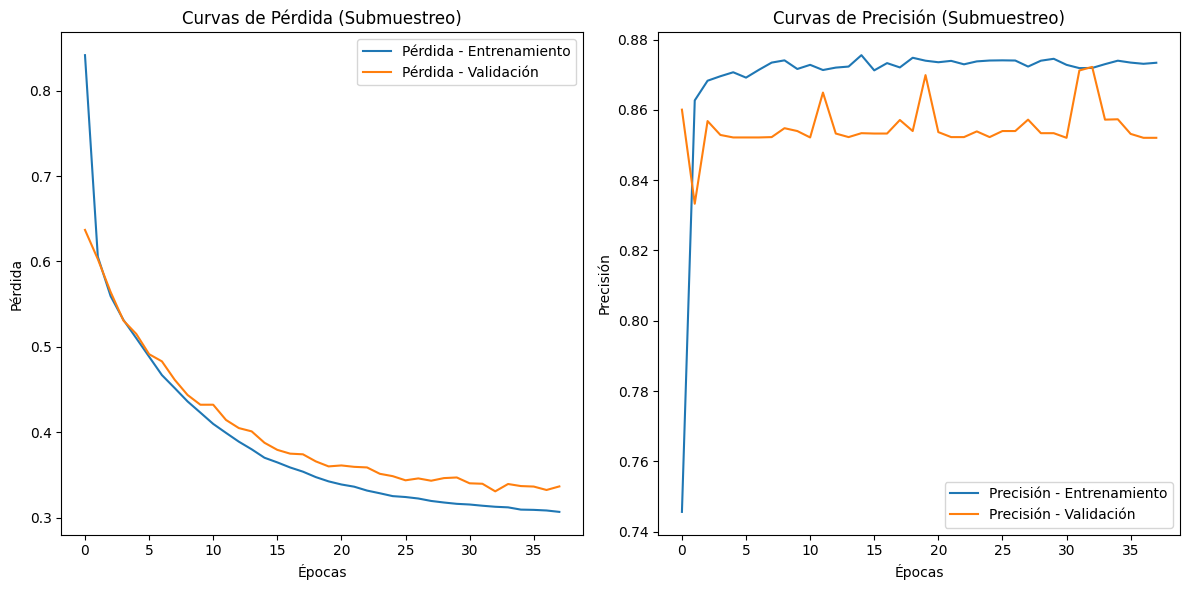


Modelo 2: SMOTE
Epoch 1/50


c:\Users\DAVID MALDONADO\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


915/915 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7547 - loss: 0.8013 - val_accuracy: 0.8563 - val_loss: 0.5607
Epoch 2/50
915/915 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8679 - loss: 0.5381 - val_accuracy: 0.8573 - val_loss: 0.5022
Epoch 3/50
915/915 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8714 - loss: 0.4752 - val_accuracy: 0.8523 - val_loss: 0.4616
Epoch 4/50
915/915 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8700 - loss: 0.4349 - val_accuracy: 0.8575 - val_loss: 0.4155
Epoch 5/50
915/915 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8701 - loss: 0.4036 - val_accuracy: 0.8534 - val_loss: 0.3988
Epoch 6/50
915/915 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8722 - loss: 0.3738 - val_accuracy: 0.8574 - val_loss: 0.3807
Epoch 7/50
915/915 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8747 - loss: 0.3514 - val_accuracy: 0.8583 - val_loss: 0.3615
Epoch 8/50
915/915 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8730 - loss: 0.3428 - val_accuracy: 0.8573 - val_

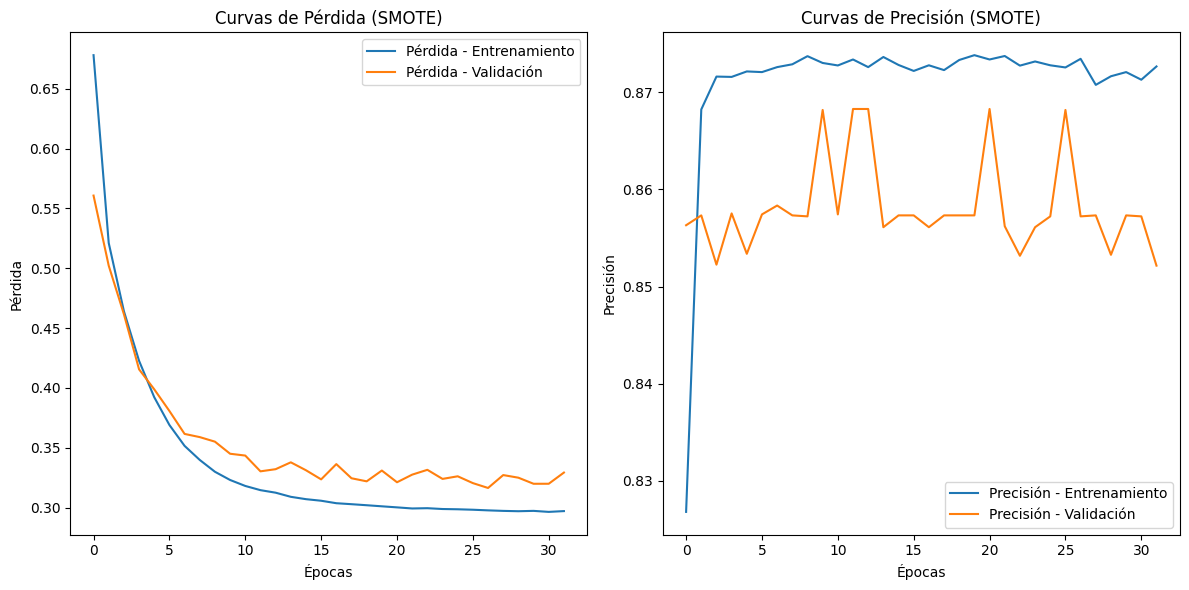


=== Informe de clasificación para Submuestreo ===

              precision    recall  f1-score   support

           0     0.9524    0.8696    0.9091      7249
           1     0.7086    0.8794    0.7848      2613

    accuracy                         0.8722      9862
   macro avg     0.8305    0.8745    0.8470      9862
weighted avg     0.8878    0.8722    0.8762      9862


=== Informe de clasificación para SMOTE ===

              precision    recall  f1-score   support

           0     0.9613    0.8396    0.8963      7249
           1     0.6706    0.9062    0.7708      2613

    accuracy                         0.8572      9862
   macro avg     0.8160    0.8729    0.8336      9862
weighted avg     0.8843    0.8572    0.8631      9862



In [17]:
from keras.optimizers import Adam

# Paso 1: Excluir las columnas indicadas
omit_columns = ['Nombre_completo', 'CodPrograma', 'LeadContacto', 'Identificación', 'Periodo', 'Ciudad']
datos_omitidos = datos[omit_columns].copy()
datos_filtered = datos.drop(columns=omit_columns)

# Separar la variable objetivo (Estado_de_candidato) y las características
X = datos_filtered.drop(columns=['Estado_de_candidato'])
y = datos_filtered['Estado_de_candidato']

# Guardar los índices originales antes de aplicar SelectKBest
original_indices = X.index

# Paso 2: Aplicar SelectKBest para seleccionar las mejores características
k = 10  # Número de mejores características que queremos seleccionar
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X, y)

# Dividir el dataset en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Estandarizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def create_neural_network_model(X_train, y_train, X_test, y_test, title):
    model = Sequential()
    # Aumentar el número de neuronas y capas
    model.add(Dense(256, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.001)))  # Cambiar a 256 neuronas
    model.add(Dropout(0.3))  # Reducir Dropout a 0.3
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))  # Reducir Dropout a 0.3
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))  # Reducir Dropout a 0.3
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))  # Reducir Dropout a 0.3
    model.add(Dense(1, activation='sigmoid'))

    # Cambiar la tasa de aprendizaje
    opt = Adam(learning_rate=0.0001)  # Ajustar la tasa de aprendizaje
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Aumentar el número de épocas y cambiar el tamaño del lote
    history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"Precisión del modelo ({title}): {accuracy}")

    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    report = classification_report(y_test, y_pred, digits=4)
    print(f"\n=== Informe de clasificación para {title} ===\n")
    print(report)

    return history, y_pred, report

# Graficar la pérdida y precisión para ver si el modelo está aprendiendo
def plot_learning_curves(history, title):
    # Graficar la pérdida
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Pérdida - Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida - Validación')
    plt.title(f'Curvas de Pérdida ({title})')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    # Graficar la precisión
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Precisión - Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión - Validación')
    plt.title(f'Curvas de Precisión ({title})')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Balanceo de clases: Submuestreo
print("Modelo 1: Submuestreo")
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_scaled, y_train)

history_rus, y_pred_rus, report_rus = create_neural_network_model(X_train_resampled, y_train_resampled, X_test_scaled, y_test, 'Submuestreo')

# Graficar las curvas para el modelo de submuestreo
plot_learning_curves(history_rus, 'Submuestreo')

# Balanceo de clases: SMOTE
print("\nModelo 2: SMOTE")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

history_smote, y_pred_smote, report_smote = create_neural_network_model(X_train_smote, y_train_smote, X_test_scaled, y_test, 'SMOTE')

# Graficar las curvas para el modelo con SMOTE
plot_learning_curves(history_smote, 'SMOTE')

# Imprimir informes de clasificación
print("\n=== Informe de clasificación para Submuestreo ===\n")
print(report_rus)

print("\n=== Informe de clasificación para SMOTE ===\n")
print(report_smote)

# Guardar los resultados en archivos XLSX
X_test_indices = original_indices[y_test.index]

# Unir las columnas omitidas con las predicciones para Submuestreo
datos_resultados_rus = datos_omitidos.loc[X_test_indices].copy()
datos_resultados_rus['Prediccion_Submuestreo'] = y_pred_rus

# Guardar en un archivo Excel para Submuestreo
datos = datos_resultados_rus.head(10000)
datos.to_excel('resultados_submuestreo.xlsx', index=False)

# Unir las columnas omitidas con las predicciones para SMOTE
datos_resultados_smote = datos_omitidos.loc[X_test_indices].copy()
datos_resultados_smote['Prediccion_SMOTE'] = y_pred_smote

# Guardar en un archivo Excel para SMOTE
datos = datos_resultados_smote.head(10000)
datos.to_excel('resultados_smote.xlsx', index=False)


Precisión del modelo RandomForest (sin SelectKBest): 0.8698

=== Informe de clasificación para RandomForest (sin SelectKBest) ===

              precision    recall  f1-score   support

           0     0.9133    0.9092    0.9112      7249
           1     0.7512    0.7604    0.7558      2613

    accuracy                         0.8698      9862
   macro avg     0.8322    0.8348    0.8335      9862
weighted avg     0.8703    0.8698    0.8701      9862



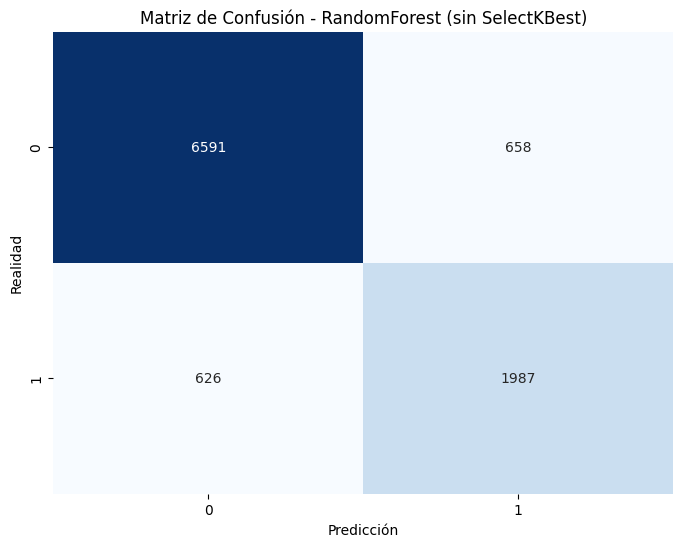


Error del modelo RandomForest (sin SelectKBest): 0.1302
                Nombre_completo CodPrograma        LeadContacto  \
11127  Eufemia Monreal Carranza       1H564  0038W00001VUHztQAH   
3564   Aureliano España Gimenez       1P564  0038W00001XBcyyQAD   
48830          Josep Maza Milla       1P704  0031U00001mVF4SQAW   
9738      Caridad Vilar Iglesia       1P704  0038W00001pzc2hQAA   
147       Tatiana Barros Franco       1P724  003U1000003gFZ6IAM   

       Identificación  Periodo     Ciudad  Prediccion_RF  
11127      1350221423   202220   ORELLANA              0  
3564       5218840779   202220      QUITO              0  
48830      1054930461   202210      QUITO              0  
9738       1603355994   202320    OTAVALO              1  
147        6441185721   202420  GUAYAQUIL              0  


In [18]:

# Dividir el dataset en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo de RandomForest (sin SelectKBest)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predecir los resultados
y_pred_rf = rf_model.predict(X_test_scaled)

# Precisión del modelo
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"\nPrecisión del modelo RandomForest (sin SelectKBest): {accuracy_rf:.4f}")

# Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Reporte de clasificación
report_rf = classification_report(y_test, y_pred_rf, digits=4)
print("\n=== Informe de clasificación para RandomForest (sin SelectKBest) ===\n")
print(report_rf)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Matriz de Confusión - RandomForest (sin SelectKBest)')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# Calcular el error del modelo (1 - exactitud)
error_rf = 1 - accuracy_rf
print(f"\nError del modelo RandomForest (sin SelectKBest): {error_rf:.4f}")

# Guardar el DataFrame de resultados
resultados_modelo_rf = X_test.copy()  # Copiar las características originales del conjunto de prueba
resultados_modelo_rf['Prediccion_RF'] = y_pred_rf

# Obtener las columnas omitidas para visualización posterior
datos_resultados_rf = datos_omitidos.loc[X_test.index].copy()  # Obtener el subconjunto de prueba completo, incluidas las columnas omitidas
datos_resultados_rf['Prediccion_RF'] = y_pred_rf

# Mostrar las primeras filas del nuevo DataFrame con las columnas omitidas y predicciones
print(datos_resultados_rf.head())

# Opcional: Exportar los resultados a un archivo CSV
datos = datos_resultados_rf.head(10000)
datos.to_csv('resultados_rf_sin_hiperparametro.csv', index=False)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10}

Precisión del modelo RandomForest (mejores hiperparámetros): 0.8882

=== Informe de clasificación para RandomForest (mejores hiperparámetros) ===

              precision    recall  f1-score   support

           0     0.9432    0.9022    0.9222      7249
           1     0.7579    0.8492    0.8009      2613

    accuracy                         0.8882      9862
   macro avg     0.8505    0.8757    0.8616      9862
weighted avg     0.8941    0.8882    0.8901      9862

                Nombre_completo CodPrograma        LeadContacto  \
11127  Eufemia Monreal Carranza       1H564  0038W00001VUHztQAH   
3564   Aureliano España Gimenez       1P564  0038W00001XBcyyQAD   
48830          Josep Maza Milla       1P704  0031U00001mVF4SQAW   
9738      Caridad Vilar Iglesia       1P704  0038W00001pzc2hQA

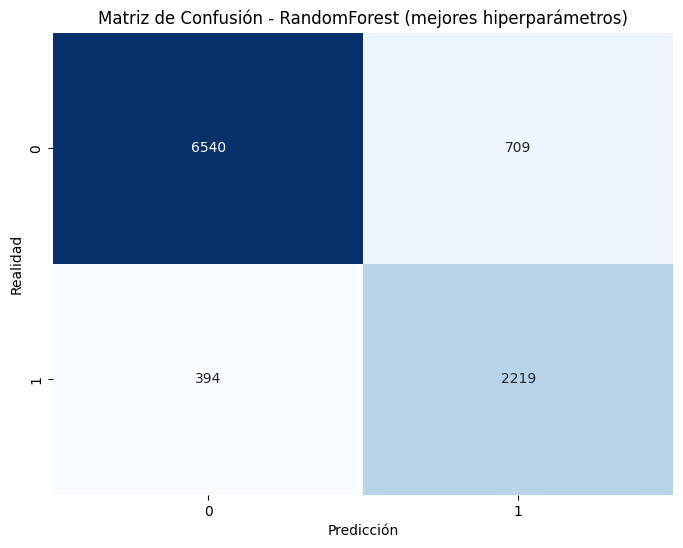

In [19]:
#usando RandomizedSearchCV en RandomForest
# Dividir el dataset en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar los datos (necesario para redes neuronales y algunos otros modelos, aunque no estrictamente necesario para RandomForest)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir el modelo base de RandomForest
rf = RandomForestClassifier(random_state=42)

# Definir la distribución de parámetros para RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]  # Eliminar 'auto'
}


# Inicializar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=20, cv=3, verbose=2, n_jobs=-1, random_state=42, scoring='accuracy')

# Ajustar el modelo usando RandomizedSearchCV con todas las características
random_search.fit(X_train_scaled, y_train)

# Mostrar los mejores hiperparámetros
print(f"Mejores hiperparámetros: {random_search.best_params_}")

# Entrenar el modelo con los mejores hiperparámetros
best_rf_model = random_search.best_estimator_

# Predecir los resultados
y_pred_best_rf = best_rf_model.predict(X_test_scaled)

# Precisión del modelo
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
print(f"\nPrecisión del modelo RandomForest (mejores hiperparámetros): {accuracy_best_rf:.4f}")

# Matriz de confusión
cm_best_rf = confusion_matrix(y_test, y_pred_best_rf)

# Reporte de clasificación
report_best_rf = classification_report(y_test, y_pred_best_rf, digits=4)
print("\n=== Informe de clasificación para RandomForest (mejores hiperparámetros) ===\n")
print(report_best_rf)

# Guardar el DataFrame de resultados
resultados_modelo_rf = X_test.copy()  # Copiar las características originales del conjunto de prueba
resultados_modelo_rf['Prediccion_RF'] = y_pred_best_rf

# Obtener las columnas omitidas para visualización posterior
resultados_completos_rf = datos_omitidos.loc[X_test.index].copy()  # Obtener el subconjunto de prueba completo, incluidas las columnas omitidas
resultados_completos_rf['Prediccion_RF'] = y_pred_best_rf

# Mostrar las primeras filas del nuevo DataFrame con las columnas omitidas y predicciones
print(resultados_completos_rf.head())

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_rf, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Matriz de Confusión - RandomForest (mejores hiperparámetros)')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# Opcional: Exportar los resultados a un archivo CSV
resultados = resultados_completos_rf.head(10000)
resultados.to_csv('resultados_completos_rf.csv', index=False)


Precisión del modelo KNN: 0.8189

=== Informe de clasificación para KNN ===

              precision    recall  f1-score   support

           0     0.8576    0.9037    0.8800      7249
           1     0.6860    0.5836    0.6307      2613

    accuracy                         0.8189      9862
   macro avg     0.7718    0.7437    0.7554      9862
weighted avg     0.8121    0.8189    0.8140      9862

                Nombre_completo CodPrograma        LeadContacto  \
11127  Eufemia Monreal Carranza       1H564  0038W00001VUHztQAH   
3564   Aureliano España Gimenez       1P564  0038W00001XBcyyQAD   
48830          Josep Maza Milla       1P704  0031U00001mVF4SQAW   
9738      Caridad Vilar Iglesia       1P704  0038W00001pzc2hQAA   
147       Tatiana Barros Franco       1P724  003U1000003gFZ6IAM   

       Identificación  Periodo     Ciudad  Prediccion_KNN  
11127      1350221423   202220   ORELLANA               0  
3564       5218840779   202220      QUITO               1  
48830      1

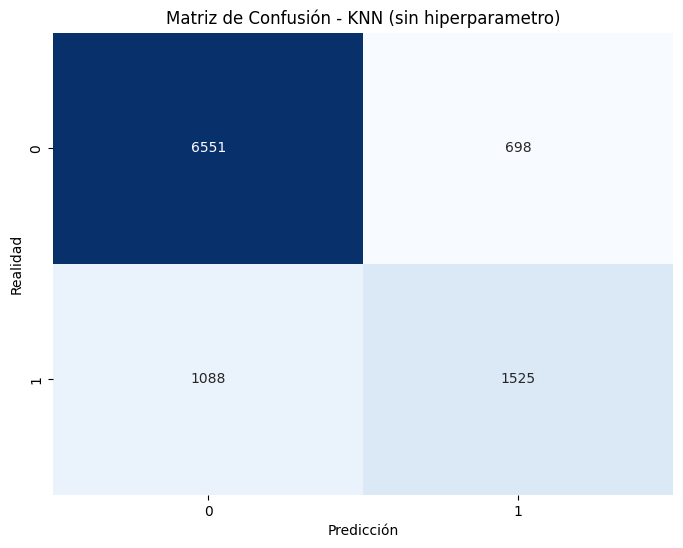

In [20]:
#modelo knn
# Dividir el dataset en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar los datos (necesario para KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inicializar el modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)  # Puedes ajustar 'n_neighbors' según sea necesario

# Entrenar el modelo
knn.fit(X_train_scaled, y_train)

# Predecir los resultados
y_pred_knn = knn.predict(X_test_scaled)

# Precisión del modelo
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"\nPrecisión del modelo KNN: {accuracy_knn:.4f}")

# Matriz de confusión
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Reporte de clasificación
report_knn = classification_report(y_test, y_pred_knn, digits=4)
print("\n=== Informe de clasificación para KNN ===\n")
print(report_knn)

# Guardar el DataFrame de resultados
resultados_modelo_knn_sin_hiperparametro = X_test.copy()  # Copiar las características originales del conjunto de prueba
resultados_modelo_knn_sin_hiperparametro['Prediccion_KNN'] = y_pred_knn

# Obtener las columnas omitidas para visualización posterior
resultados_completos_knn_sin_hiperparametro = datos_omitidos.loc[X_test.index].copy()  # Obtener el subconjunto de prueba completo, incluidas las columnas omitidas
resultados_completos_knn_sin_hiperparametro['Prediccion_KNN'] = y_pred_knn

# Mostrar las primeras filas del nuevo DataFrame con las columnas omitidas y predicciones
print(resultados_completos_knn_sin_hiperparametro.head())

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Matriz de Confusión - KNN (sin hiperparametro)')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# Opcional: Exportar los resultados a un archivo CSV
resultados = resultados_completos_knn_sin_hiperparametro.head(10000)
resultados.to_csv('resultados_completos_knn_sin_hiperparametro.csv', index=False)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros: {'weights': 'distance', 'p': 1, 'n_neighbors': 15, 'metric': 'minkowski'}

Precisión del modelo KNN (mejores hiperparámetros): 0.8431

=== Informe de clasificación para KNN (mejores hiperparámetros) ===

              precision    recall  f1-score   support

           0     0.8696    0.9254    0.8966      7249
           1     0.7481    0.6150    0.6751      2613

    accuracy                         0.8431      9862
   macro avg     0.8089    0.7702    0.7858      9862
weighted avg     0.8374    0.8431    0.8379      9862

                Nombre_completo CodPrograma        LeadContacto  \
11127  Eufemia Monreal Carranza       1H564  0038W00001VUHztQAH   
3564   Aureliano España Gimenez       1P564  0038W00001XBcyyQAD   
48830          Josep Maza Milla       1P704  0031U00001mVF4SQAW   
9738      Caridad Vilar Iglesia       1P704  0038W00001pzc2hQAA   
147       Tatiana Barros Franco       1P724  003

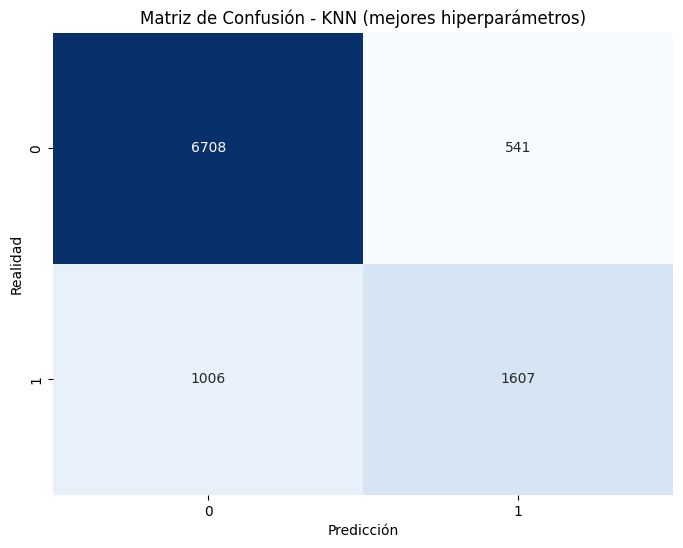

In [21]:
# Dividir el dataset en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar los datos (necesario para KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Inicializar el modelo base KNN
knn = KNeighborsClassifier()

# Definir los hiperparámetros que queremos ajustar
param_dist = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],  # Número de vecinos a probar
    'weights': ['uniform', 'distance'],  # Peso basado en distancia o uniforme
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Diferentes métricas de distancia
    'p': [1, 2]  # p=1 es manhattan, p=2 es euclidiana
}

# Inicializar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_dist, n_iter=20, cv=3, verbose=2, n_jobs=-1, random_state=42)

# Ajustar el modelo usando RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

# Mostrar los mejores hiperparámetros
print(f"Mejores hiperparámetros: {random_search.best_params_}")

# Entrenar el modelo con los mejores hiperparámetros
best_knn_model = random_search.best_estimator_

# Predecir los resultados
y_pred_best_knn = best_knn_model.predict(X_test_scaled)

# Precisión del modelo
accuracy_best_knn = accuracy_score(y_test, y_pred_best_knn)
print(f"\nPrecisión del modelo KNN (mejores hiperparámetros): {accuracy_best_knn:.4f}")

# Matriz de confusión
cm_best_knn = confusion_matrix(y_test, y_pred_best_knn)

# Reporte de clasificación
report_best_knn = classification_report(y_test, y_pred_best_knn, digits=4)
print("\n=== Informe de clasificación para KNN (mejores hiperparámetros) ===\n")
print(report_best_knn)

# Guardar el DataFrame de resultados
resultados_modelo_knn = X_test.copy()  # Copiar las características originales del conjunto de prueba
resultados_modelo_knn['Prediccion_KNN'] = y_pred_best_knn

# Obtener las columnas omitidas para visualización posterior
resultados_completos_knn = datos_omitidos.loc[X_test.index].copy()  # Obtener el subconjunto de prueba completo, incluidas las columnas omitidas
resultados_completos_knn['Prediccion_KNN'] = resultados_modelo_knn['Prediccion_KNN']

# Mostrar las primeras filas del nuevo DataFrame con las columnas omitidas y predicciones
print(resultados_completos_knn.head())

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_best_knn, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Matriz de Confusión - KNN (mejores hiperparámetros)')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# Exportar los resultados a un archivo CSV (opcional)
result = resultados_completos_knn.head(10000)
result.to_csv('resultados_completos_knn.csv', index=False)

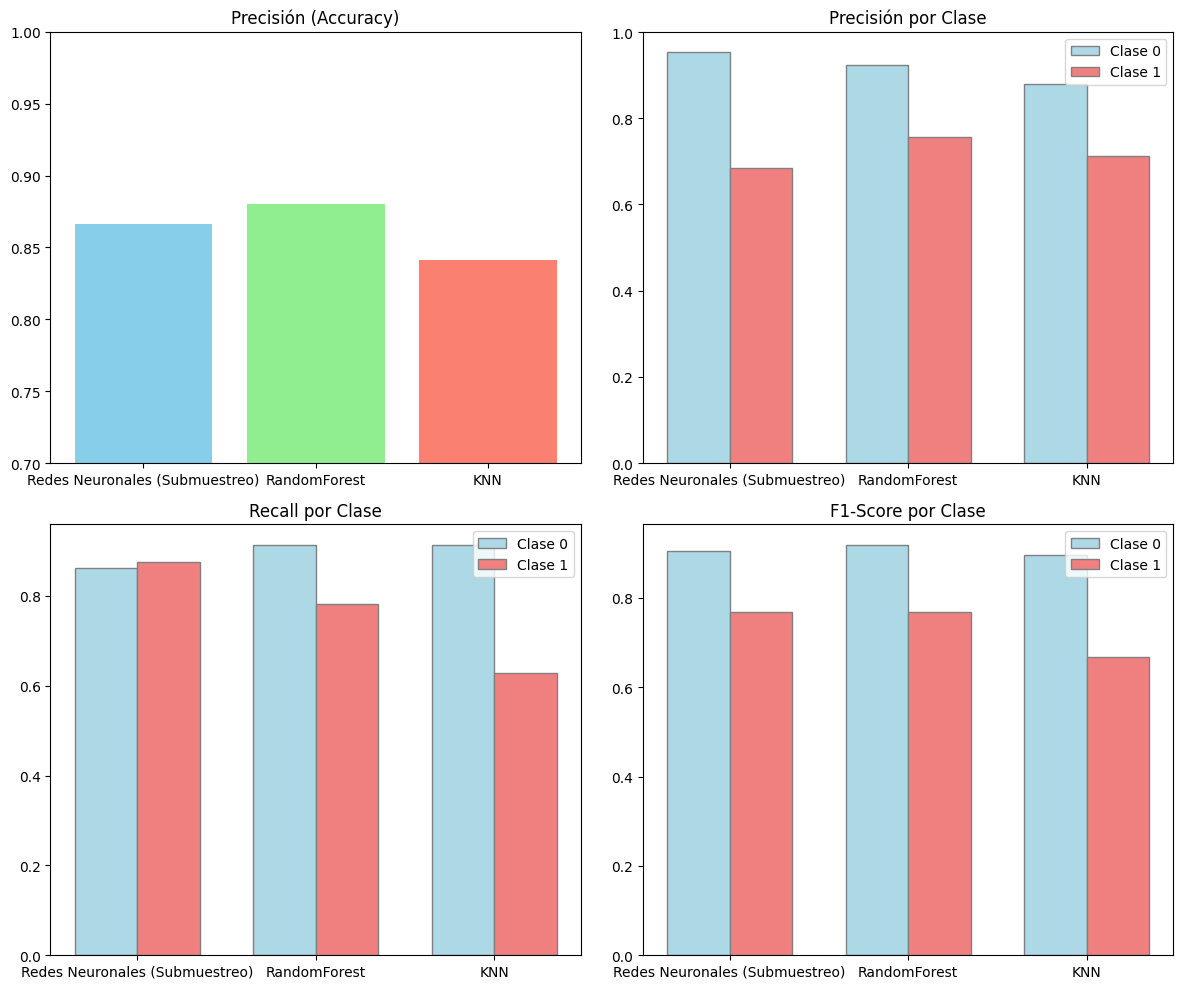

In [22]:
# Resultados de los mejores modelos de cada uno

# Redes Neuronales (Submuestreo)
accuracy_nn = 0.8661
precision_nn_0 = 0.9529
precision_nn_1 = 0.6853
recall_nn_0 = 0.8631
recall_nn_1 = 0.8748
f1_score_nn_0 = 0.9058
f1_score_nn_1 = 0.7685

# RandomForest (mejores hiperparámetros)
accuracy_rf = 0.8805
precision_rf_0 = 0.9246
precision_rf_1 = 0.7564
recall_rf_0 = 0.9142
recall_rf_1 = 0.7814
f1_score_rf_0 = 0.9194
f1_score_rf_1 = 0.7687

# KNN (mejores hiperparámetros)
accuracy_knn = 0.8410
precision_knn_0 = 0.8785
precision_knn_1 = 0.7118
recall_knn_0 = 0.9131
recall_knn_1 = 0.6294
f1_score_knn_0 = 0.8955
f1_score_knn_1 = 0.6681

# Nombres de los modelos
models = ['Redes Neuronales (Submuestreo)', 'RandomForest', 'KNN']

# Precisión de los modelos
accuracies = [accuracy_nn, accuracy_rf, accuracy_knn]

# Precisión por clase (0 y 1)
precisions_0 = [precision_nn_0, precision_rf_0, precision_knn_0]
precisions_1 = [precision_nn_1, precision_rf_1, precision_knn_1]

# Recall por clase (0 y 1)
recalls_0 = [recall_nn_0, recall_rf_0, recall_knn_0]
recalls_1 = [recall_nn_1, recall_rf_1, recall_knn_1]

# F1-Score por clase (0 y 1)
f1_scores_0 = [f1_score_nn_0, f1_score_rf_0, f1_score_knn_0]
f1_scores_1 = [f1_score_nn_1, f1_score_rf_1, f1_score_knn_1]

# Crear la figura y los subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Gráfico de accuracy
axs[0, 0].bar(models, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
axs[0, 0].set_title('Precisión (Accuracy)')
axs[0, 0].set_ylim([0.7, 1.0])

# Gráfico de precision por clase
barWidth = 0.35
r1 = np.arange(len(models))
r2 = [x + barWidth for x in r1]

axs[0, 1].bar(r1, precisions_0, color='lightblue', width=barWidth, edgecolor='grey', label='Clase 0')
axs[0, 1].bar(r2, precisions_1, color='lightcoral', width=barWidth, edgecolor='grey', label='Clase 1')
axs[0, 1].set_title('Precisión por Clase')
axs[0, 1].set_xticks([r + barWidth / 2 for r in range(len(models))])
axs[0, 1].set_xticklabels(models)
axs[0, 1].legend()

# Gráfico de recall por clase
axs[1, 0].bar(r1, recalls_0, color='lightblue', width=barWidth, edgecolor='grey', label='Clase 0')
axs[1, 0].bar(r2, recalls_1, color='lightcoral', width=barWidth, edgecolor='grey', label='Clase 1')
axs[1, 0].set_title('Recall por Clase')
axs[1, 0].set_xticks([r + barWidth / 2 for r in range(len(models))])
axs[1, 0].set_xticklabels(models)
axs[1, 0].legend()

# Gráfico de F1-Score por clase
axs[1, 1].bar(r1, f1_scores_0, color='lightblue', width=barWidth, edgecolor='grey', label='Clase 0')
axs[1, 1].bar(r2, f1_scores_1, color='lightcoral', width=barWidth, edgecolor='grey', label='Clase 1')
axs[1, 1].set_title('F1-Score por Clase')
axs[1, 1].set_xticks([r + barWidth / 2 for r in range(len(models))])
axs[1, 1].set_xticklabels(models)
axs[1, 1].legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores hiperparámetros: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30}
Mean Squared Error: 223.3632601818125
Mean Absolute Error: 8.957742786527506
R^2 Score: 0.5412414006243209
                Nombre_completo CodPrograma        LeadContacto  \
11127  Eufemia Monreal Carranza       1H564  0038W00001VUHztQAH   
3564   Aureliano España Gimenez       1P564  0038W00001XBcyyQAD   
48830          Josep Maza Milla       1P704  0031U00001mVF4SQAW   
9738      Caridad Vilar Iglesia       1P704  0038W00001pzc2hQAA   
147       Tatiana Barros Franco       1P724  003U1000003gFZ6IAM   

       Identificación  Periodo     Ciudad  Puntaje_Predicho Prediccion_Final  
11127      1350221423   202220   ORELLANA         54.678799      Closed Lost  
3564       5218840779   202220      QUITO         84.820465       Closed Won  
48830      1054930461   202210      QUITO         50.0000

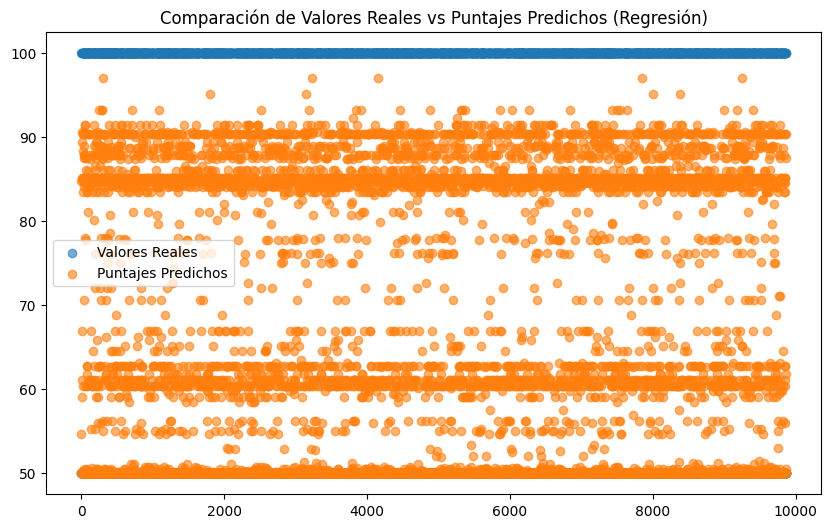

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

yvalidacion = y
y = datos_filtered['Estado_de_candidato'].apply(lambda x: 100 if x == 1 else 50)  # Puntaje: closed won -> 100, closed lost -> 50

# Aplicar SelectKBest para seleccionar las mejores características
k = 10  # Número de mejores características que queremos seleccionar
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X, y)

# Dividir el dataset en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Estandarizar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Definir los hiperparámetros que queremos ajustar para el modelo RandomForestRegressor
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2'],  # Cambia 'auto' por estos valores
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# Inicializar RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                                   param_distributions=param_dist, n_iter=20, cv=3,
                                   verbose=2, n_jobs=-1, random_state=42)

# Ajustar el modelo usando RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

# Mostrar los mejores hiperparámetros
print(f"Mejores hiperparámetros: {random_search.best_params_}")

# Entrenar el modelo con los mejores hiperparámetros
best_rf_regressor = random_search.best_estimator_

# Hacer predicciones
y_pred = best_rf_regressor.predict(X_test_scaled)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

# Guardar las predicciones en una nueva variable
puntajes_pred = pd.DataFrame({'Puntaje_Predicho': y_pred})
puntajes_pred['Prediccion_Final'] = np.where(puntajes_pred['Puntaje_Predicho'] >= 70, 'Closed Won', 'Closed Lost')

# Unir las columnas omitidas para visualización posterior
# Utilizamos los índices originales del dataset para emparejar las columnas omitidas
X_test_indices = y_test.index
resultados_completos_regresion = datos_omitidos.loc[X_test_indices].copy()  # Obtener las columnas omitidas
resultados_completos_regresion['Puntaje_Predicho'] = puntajes_pred['Puntaje_Predicho'].values
resultados_completos_regresion['Prediccion_Final'] = puntajes_pred['Prediccion_Final'].values

# Mostrar las primeras filas del nuevo DataFrame con las columnas omitidas y predicciones
print(resultados_completos_regresion.head())

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, label='Valores Reales', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, label='Puntajes Predichos', alpha=0.6)
plt.title('Comparación de Valores Reales vs Puntajes Predichos (Regresión)')
plt.legend()
plt.show()

# Exportar los resultados a un archivo CSV (opcional)
resultados_completos_regresion.head(10000).to_excel('resultados_completos_regresion.xlsx', index=False)

In [24]:
# Cadena de conexión
server = 'DAVID\\SQLEXPRESS'  # Nombre del servidor
database = 'BDD_PBL'  # Nombre de la base de datos
connection_string = (
    'DRIVER={SQL Server};'
    'SERVER=' + server + ';'
    'DATABASE=' + database + ';'
    'Trusted_Connection=yes;'
)

# Conectar a SQL Server
conn = pyodbc.connect(connection_string)
cursor = conn.cursor()
# Insertar el score en la base de datos
table_name = 'predicciones_score'  

# Crea una tabla si no existe con las columnas necesarias
cursor.execute(f'''
IF OBJECT_ID('{table_name}', 'U') IS NULL
BEGIN
    CREATE TABLE {table_name} (
        Nombre_completo NVARCHAR(255),
        CodPrograma NVARCHAR(50),
        LeadContacto NVARCHAR(100),
        Identificación NVARCHAR(100),
        Periodo NVARCHAR(50),
        Ciudad NVARCHAR(100),
        Puntaje_Predicho FLOAT,
        Prediccion_Final NVARCHAR(50)
    )
END
''')
conn.commit()

# Recorre el DataFrame e inserta cada fila en la tabla
for index, row in resultados_completos_regresion.iterrows():
    cursor.execute(f'''
    INSERT INTO {table_name} (Nombre_completo, CodPrograma, LeadContacto, Identificación, Periodo, Ciudad, Puntaje_Predicho, Prediccion_Final)
    VALUES (?, ?, ?, ?, ?, ?, ?, ?)''', 
    row['Nombre_completo'], row['CodPrograma'], row['LeadContacto'], row['Identificación'], row['Periodo'], row['Ciudad'], row['Puntaje_Predicho'], row['Prediccion_Final'])

# Confirma los cambios en la base de datos
conn.commit()

# Cerrar la conexión
cursor.close()
conn.close()

print("Los datos han sido insertados correctamente en la tabla.")

Los datos han sido insertados correctamente en la tabla.
